# **Battery Aging Analysis Using EIS and Charge/Discharge Data**

## **Introduction**
This notebook investigates battery aging by analyzing **Li-ion battery** datasets that include:
- **Electrochemical Impedance Spectroscopy (EIS) measurements** across cycles.
- **Charge/Discharge cycles** to track capacity degradation.
- **Machine learning predictions** for battery health.

We will:
1. **Visualize impedance changes** over aging using a **3D plot**.
2. **Perform Incremental Capacity Analysis (`dQ/dV vs. Cycle Count`)**.
3. **Detect and track peaks** in `dQ/dV` over time.
4. **Train a model to predict capacity** based on impedance and temperature.

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load Dataset
battery_data = pd.read_csv('merged_data.csv')

# Convert relevant columns to numeric
battery_data['ambient_temperature'] = pd.to_numeric(battery_data['ambient_temperature'], errors='coerce')
battery_data['test_id'] = pd.to_numeric(battery_data['test_id'], errors='coerce')
battery_data['Capacity'] = pd.to_numeric(battery_data['Capacity'], errors='coerce')
battery_data['Re'] = pd.to_numeric(battery_data['Re'], errors='coerce')
battery_data['Rct'] = pd.to_numeric(battery_data['Rct'], errors='coerce')

# Drop missing values in key columns
battery_data_clean = battery_data.dropna(subset=['test_id'])

# Display first few rows
battery_data_clean.head()


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,File_Name
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.674305,NaN,NaN,metadata.csv
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.056058,0.200970,metadata.csv
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN,metadata.csv
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.053192,0.164734,metadata.csv
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.524366,NaN,NaN,metadata.csv


### **Output Explanation:**
Above, we load the dataset and ensure that all key columns are numeric.

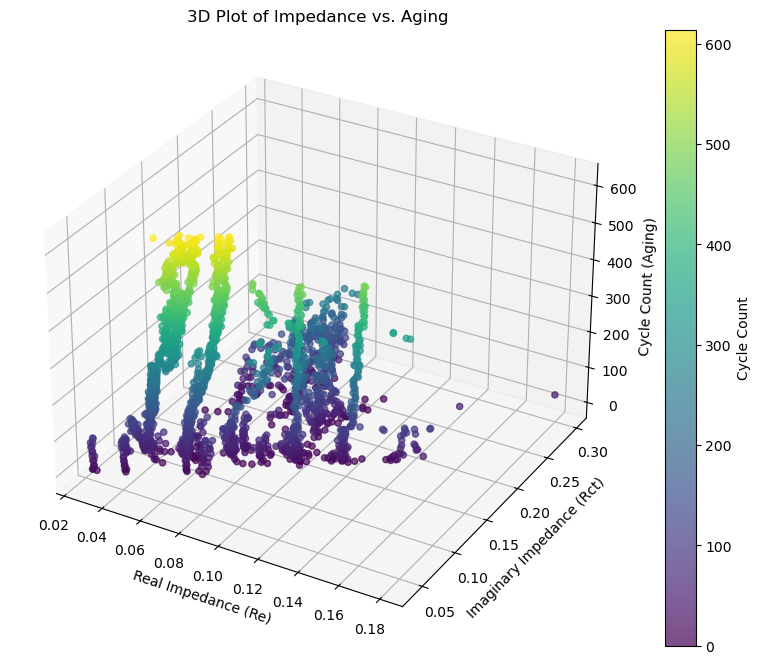

In [3]:
# Remove outliers from impedance data
impedance_data = battery_data_clean.dropna(subset=['Re', 'Rct'])
impedance_data = impedance_data[(impedance_data['Re'] > 0) & (impedance_data['Re'] < 1) &
                                (impedance_data['Rct'] > 0) & (impedance_data['Rct'] < 1)]

# 3D Plot: Impedance vs Aging
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(impedance_data['Re'], impedance_data['Rct'], impedance_data['test_id'], 
                c=impedance_data['test_id'], cmap='viridis', alpha=0.7)

ax.set_xlabel('Real Impedance (Re)')
ax.set_ylabel('Imaginary Impedance (Rct)')
ax.set_zlabel('Cycle Count (Aging)')
fig.colorbar(sc, ax=ax, label='Cycle Count')

ax.set_title('3D Plot of Impedance vs. Aging')
plt.show()


### **Output Explanation:**
This 3D plot shows how real and imaginary impedance evolve over battery cycles. We filter unrealistic values (`Re`, `Rct` < 1Ω) to improve clarity.

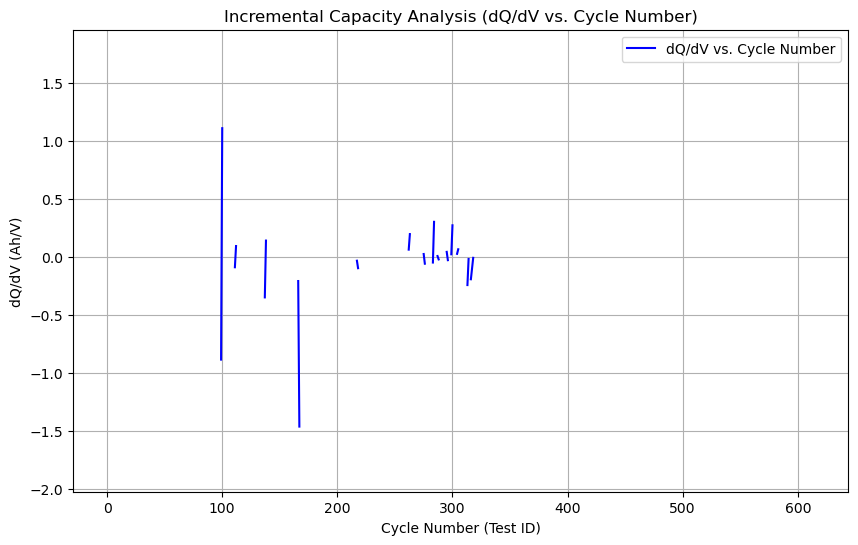

In [5]:
# Incremental Capacity Analysis (dQ/dV vs. Cycle Count)
discharge_data = battery_data_clean[battery_data_clean['type'] == 'discharge'].dropna(subset=['Capacity'])

discharge_data = discharge_data.sort_values(by=['test_id'])
discharge_data['dQ'] = discharge_data['Capacity'].diff()
discharge_data['dV'] = discharge_data['test_id'].diff()  # Using test_id as a proxy for voltage
discharge_data['dQ/dV'] = discharge_data['dQ'] / discharge_data['dV']

# Remove NaN values after differentiation
discharge_data_cleaned = discharge_data.dropna(subset=['dQ/dV'])

plt.figure(figsize=(10, 6))
plt.plot(discharge_data_cleaned['test_id'], discharge_data_cleaned['dQ/dV'], label='dQ/dV vs. Cycle Number', color='b')

plt.xlabel('Cycle Number (Test ID)')
plt.ylabel('dQ/dV (Ah/V)')
plt.title('Incremental Capacity Analysis (dQ/dV vs. Cycle Number)')
plt.grid(True)
plt.legend()
plt.show()


### **Output Explanation:**
This plot shows how incremental capacity (`dQ/dV`) changes with battery aging. Spikes indicate phase transitions or internal resistance shifts.

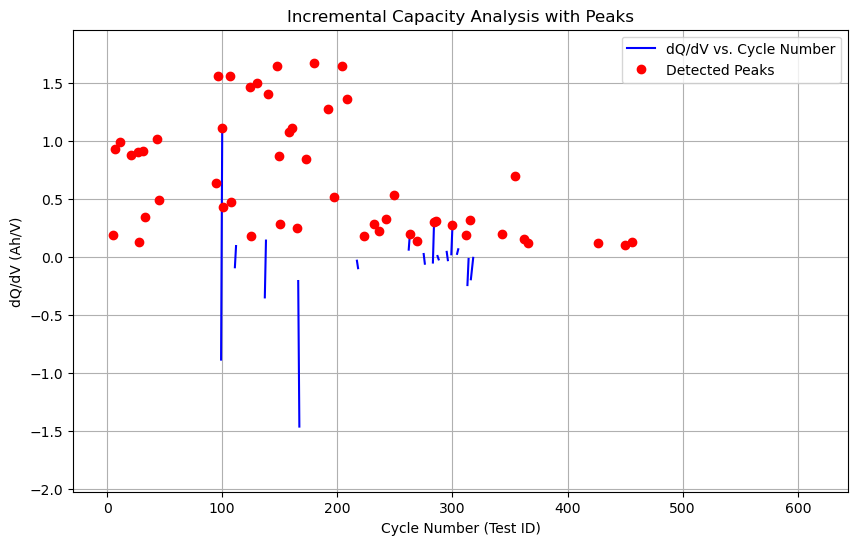

In [7]:
# Detect Peaks in dQ/dV Analysis
peaks, _ = find_peaks(discharge_data_cleaned['dQ/dV'], height=0.1)

plt.figure(figsize=(10, 6))
plt.plot(discharge_data_cleaned['test_id'], discharge_data_cleaned['dQ/dV'], label='dQ/dV vs. Cycle Number', color='b')
plt.plot(discharge_data_cleaned['test_id'].iloc[peaks], discharge_data_cleaned['dQ/dV'].iloc[peaks], 'ro', label='Detected Peaks')

plt.xlabel('Cycle Number (Test ID)')
plt.ylabel('dQ/dV (Ah/V)')
plt.title('Incremental Capacity Analysis with Peaks')
plt.grid(True)
plt.legend()
plt.show()


### **Output Explanation:**
Red points indicate peak values in `dQ/dV`. Tracking these helps understand battery degradation over time.

Mean Absolute Error: 0.19069219180439742
R² Score: 0.6118840613591815


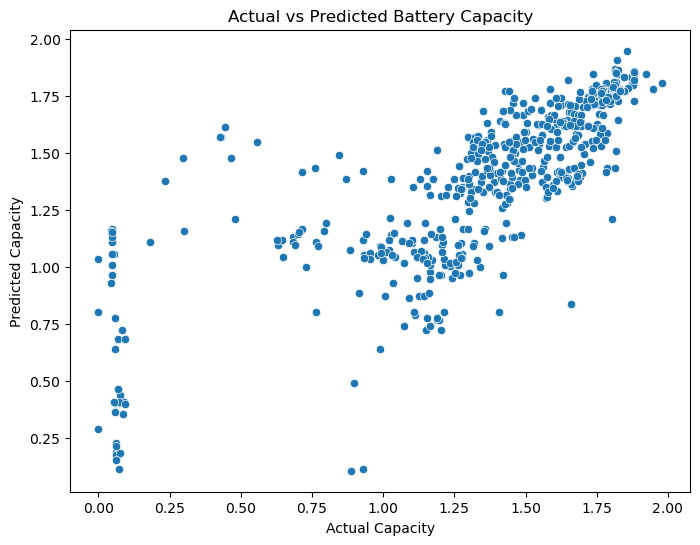

In [9]:
# Machine Learning Model for Capacity Prediction

# Define features and target
features = ['ambient_temperature', 'test_id']
ml_data = battery_data.dropna(subset=features + ['Capacity'])

X = ml_data[features]
y = ml_data['Capacity']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred = rf.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(rf, 'battery_capacity_model.pkl')

# Plot Predictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.title('Actual vs Predicted Battery Capacity')
plt.show()


### **Output Explanation:**
We train a Random Forest model to predict battery capacity using temperature and cycle count. The scatter plot shows model accuracy.